In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import string
import os
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
os.environ['KERAS_BACKEND']='theano' # Why theano why not
os.environ['OMP_NUM_THREADS']='10' # Why theano why not

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
import matplotlib.pyplot as plt
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
plt.switch_backend('agg')
%matplotlib inline

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\elham\appdata\local\programs\python\python37\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%env OMP_NUM_THREADS=10

env: OMP_NUM_THREADS=10


In [3]:
df = pd.read_csv("emails.csv")
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)

Shape of dataset  (5728, 2)
Index(['text', 'spam'], dtype='object')


In [4]:
np.sum(df.spam)

1368

In [5]:
np.random.seed(4)
indices = np.arange(df['text'].shape[0])
np.random.shuffle(indices)
bodys = df.text[indices]
ids = df.spam[indices]

In [6]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
sample_length = 100;

In [7]:
def clean_str(s):
    
    porter = PorterStemmer()
    s = s.translate(str.maketrans('', '', string.punctuation))
    s_new = ''
    for word in s.split(' '):
        s_new = s_new + ' ' + porter.stem(word)
    return s_new.strip().lower()

In [8]:
texts = []
labels = []

#df.Phrase.shape[0]
for idx in range(sample_length):
    text = bodys[idx]   #.split(': ',1)[1]
    text = clean_str(text)
    texts.append(text)

for label in ids[:sample_length]:
    labels.append(label)

In [9]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)  # intialize the tokenizer in Keras
tokenizer.fit_on_texts(texts)    # make a dictinary of all the unique words in all the input texts and 
# order them based on their frequency
sequences = tokenizer.texts_to_sequences(texts)  # conver the sequence of the words to a sequence of indexes 
# according to the location of that word in the created dict

word_index = tokenizer.word_index   
ls = list(word_index.items())
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 3419


In [10]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels_bin = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels_bin.shape)

np.random.seed(42)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_bin = labels_bin[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels_bin[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels_bin[-nb_validation_samples:]

Shape of Data Tensor: (100, 1000)
Shape of Label Tensor: (100, 2)


In [11]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))


Total 400000 word vectors in Glove 6B 100d.


In [12]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i % 100 == 0:
        print('i=',i)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=False)

i= 100
i= 200
i= 300
i= 400
i= 500
i= 600
i= 700
i= 800
i= 900
i= 1000
i= 1100
i= 1200
i= 1300
i= 1400
i= 1500
i= 1600
i= 1700
i= 1800
i= 1900
i= 2000
i= 2100
i= 2200
i= 2300
i= 2400
i= 2500
i= 2600
i= 2700
i= 2800
i= 2900
i= 3000
i= 3100
i= 3200
i= 3300
i= 3400


In [15]:
filter_size = 5
lambd = 0.01
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
print('embeding')
l_cov1= Conv1D(128, filter_size, activation='relu', activity_regularizer=l2(lambd))(embedded_sequences)
l_pool1 = MaxPooling1D(filter_size)(l_cov1)
print('layer1')

l_cov2 = Conv1D(128, filter_size, activation='relu', activity_regularizer=l2(lambd))(l_pool1)
l_pool2 = MaxPooling1D(filter_size)(l_cov2)
print('layer2')

l_cov3 = Conv1D(128, filter_size, activation='relu', activity_regularizer=l2(lambd))(l_pool2)
l_pool3 = MaxPooling1D(7*filter_size)(l_cov3)  # global max pooling
print('layer3')

#l_cov4 = Conv1D(128, filter_size, activation='relu')(l_pool3)
#l_pool4 = MaxPooling1D(2*filter_size)(l_cov4)  # global max pooling
#print('layer4')

l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu', activity_regularizer=l2(lambd))(l_flat)
preds = Dense(labels_bin.shape[1], activation='softmax')(l_dense)
print('layer4')
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

embeding
layer1
layer2
layer3
layer4
Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         342000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________

In [16]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 80 samples, validate on 20 samples
Epoch 1/15
80/80 [==============================] - 1177s 15s/step - loss: 29.9764 - acc: 0.7500 - val_loss: 2.5863 - val_acc: 0.8500

Epoch 00001: val_acc improved from -inf to 0.85000, saving model to model_cnn.hdf5
Epoch 2/15
80/80 [==============================] - 1177s 15s/step - loss: 1.7019 - acc: 0.7750 - val_loss: 0.8213 - val_acc: 0.8500

Epoch 00002: val_acc did not improve from 0.85000
Epoch 3/15
80/80 [==============================] - 1177s 15s/step - loss: 0.7721 - acc: 0.7750 - val_loss: 0.6584 - val_acc: 0.8500

Epoch 00003: val_acc did not improve from 0.85000
Epoch 4/15
80/80 [==============================] - 1178s 15s/step - loss: 0.6335 - acc: 0.7750 - val_loss: 0.5865 - val_acc: 0.8500

Epoch 00004: val_acc did not improve from 0.85000
Epoch 5/15
80/80 [==============================] - 1177s 15s/step - loss: 0.5432 - acc: 0.7750 - val_loss: 0.6082 - val_acc: 0.8500

Epoch 00005: val_acc did not improve from 0.85000
Ep

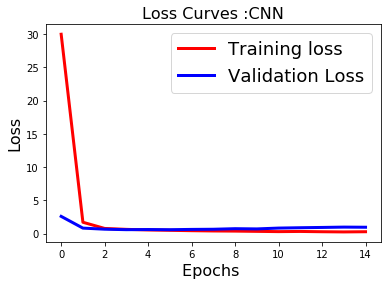

In [17]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

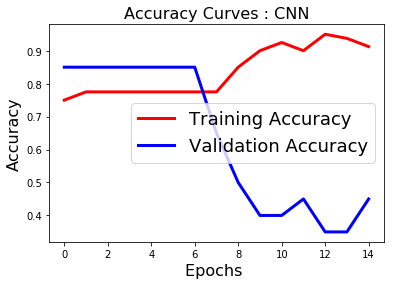

In [18]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [ ]:
#preds = ourModel.evaluate(x =X_test, y =Y_test)
### END CODE HERE ###
#print()
#print ("Loss = " + str(preds[0]))
#print ("Test Accuracy = " + str(preds[1]))